## Vision Transformer

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data.dataloader as dataloader

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange

In [4]:
batch_size = 128
num_epochs = 50
learning_rate = 1e-4
root_dataset = "../datasets"
patch_size=4

In [5]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

### prepare the dataset

In [6]:
train_transform = transforms.Compose([transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])
    
])

test_transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])
])



### Train test and validation

In [9]:
import torch.utils


train_data = datasets.CIFAR10(root_dataset, train=True, transform=train_transform, download=True)
test_data = datasets.CIFAR10(root_dataset, train=False, transform=test_transform, download=True)

## Further split dataset into 10/90
validation_split = 0.9

n_train_sample = int(len(train_data) * validation_split)
n_val_sample = len(train_data) - n_train_sample

trian_data, val_data = torch.utils.data.random_split(train_data, [n_train_sample, n_val_sample],
                                                     generator=torch.Generator().manual_seed(42))

Files already downloaded and verified
Files already downloaded and verified


In [11]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(val_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 50000
Number of validation examples: 5000
Number of testing examples: 10000


In [12]:
train_loader = dataloader.DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_loader = dataloader.DataLoader(val_data, batch_size=batch_size)
test_loader = dataloader.DataLoader(test_data, batch_size=batch_size)

### View patches

In [18]:
def extract_patches(image_tensor, patch_size=8):
    batch_size, color_channel, hieght, width = image_tensor.shape
    unfold = nn.Unfold(kernel_size=patch_size, stride=patch_size)
    unfloded = unfold(image_tensor)
    
    unfloded = unfloded.transpose(1, 2).reshape(batch_size, -1 , color_channel * patch_size * patch_size)
    return unfloded

In [19]:
test_image, test_label = next(iter(test_loader))

In [20]:
test_image.shape, test_label.shape

(torch.Size([128, 3, 32, 32]), torch.Size([128]))

In [25]:
32//4

8

Sequence Length 64


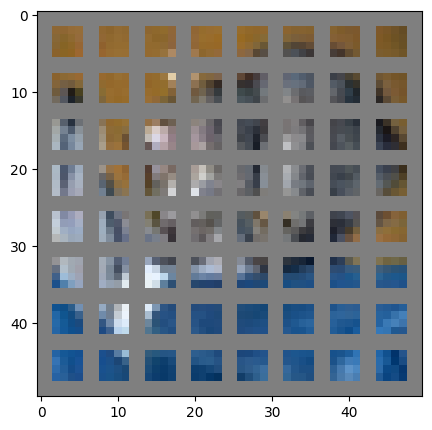

In [21]:
patches = extract_patches(test_image, patch_size=patch_size)
patch_square = patches.reshape(test_image.shape[0], -1, 3, patch_size, patch_size)

# Calculate the grid size for visualization
grid_size = test_image.shape[2] // patch_size
print("Sequence Length %d" % (grid_size**2))

# Visualize the patches as a grid
plt.figure(figsize=(5, 5))
out = torchvision.utils.make_grid(patch_square[0], grid_size, normalize=True, pad_value=0.5)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

In [34]:
patches.shape

torch.Size([128, 64, 48])

### Model implementation

In [33]:
class TransformerBlock(nn.Module):
    
    def __init__(self, hidden_size=128, num_heads=4):
        super(TransformerBlock, self).__init__()
        
        self.norm1 = nn.LayerNorm(hidden_size)
        self.multihead_attn = nn.MultiheadAttention(embed_dim=hidden_size,  num_heads=num_heads, dropout=0.5,
                                                    batch_first=True)
        
        self.norm2 = nn.LayerNorm(hidden_size)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_size, 2 * hidden_size),
            nn.LayerNorm(2*hidden_size),
            nn.ELU(),
            nn.Linear(2 * hidden_size, hidden_size)
        )
        
    def forward(self, x):
        norm_x = self.norm1(x)
        
        x = self.multihead_attn(norm_x, norm_x, norm_x)[0] + x
        
        norm_x = self.norm2(x)
        
        x = self.mlp(norm_x) + x
        return x

In [ ]:
class Vit(nn.Module):
    
    def __init__(self, image_size, channels_size, patch_size, hidden_size, num_layers, num_heads=8):
        super(Vit, self).__init__()
        
        self.patch_size = patch_size
        self.fc_in = nn.Linear(channels_size * patch_size * patch_size, hidden_size)
        
        self.blocks = nn.ModuleList(
            [TransformerBlock(hidden_size=hidden_size, num_heads=num_heads) for _ in range(num_layers)]
        )
        
        self.fc_out = nn.Linear(hidden_size, 10)
        
        self.out_vec = nn.Parameter(torch.zeros(1, 1, hidden_size))
        
        self.seq_len = (image_size // patch_size) ** 2
        self.pos_embedding = nn.Parameter(torch.empty(1, self.seq_len, hidden_size).normal_(std=0.001))
        
    def forward(self, x):
        batch_size = x.shape[0]
        
        patch_sequence = extract_patches(x, self.patch_size)
        patch_embeding = self.fc_in(patch_sequence)        
        patch_embeding = patch_embeding + self.pos_embedding
        
        # Concatenate the output token to the patch embeddings
        embs = torch.cat((self.out_vec.expand(batch_size, 1, -1), patch_embeding), 1)
        
        for block in self.blocks:
            embs = block(embs)
        
        return self.fc_out(embs[:, 0])
        